In [35]:
%pip install scipy numpy matplotlib pyyaml --quiet

Note: you may need to restart the kernel to use updated packages.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

In [37]:
def get_params(config):
    try:
        # Acessa as configurações aninhadas
        ds = config['DATASET']
        rf = config['RF_FRONT_END']
        gps = config['GPS_STANDARD']
        acq = config['ACQUISITION']

        # 1. Extração de Variáveis Base (Conversão de Tipo)
        
        FILENAME = ds['FILENAME']
        # Converte a string 'int8' para o tipo numpy.int8
        DATA_DTYPE = getattr(np, ds['DTYPE']) 
        PRN_ID_TO_SEARCH = ds['PRN_ID_TO_SEARCH']
        
        FS = rf['FS']
        FIF = rf['FIF']
        
        PRN_CHIP_RATE = gps['PRN_CHIP_RATE']
        PRN_LENGTH = gps['PRN_LENGTH']
        
        DOPPLER_RANGE = acq['DOPPLER_RANGE']
        DOPPLER_STEP = acq['DOPPLER_STEP']
        TIME_TO_PROCESS = acq['TIME_TO_PROCESS']

        # 2. Cálculo de Parâmetros Derivados
        
        # Amostras por Chip (define o superamostragem da réplica do código)
        SAMPLES_PER_CHIP = round(FS / PRN_CHIP_RATE)

        # Alguns arquivos de configuração podem fornecer PRN_LENGTH já em amostras
        # (ex: 16368 = 1023 chips * 16 amostras/chip). Detectamos esse caso e
        # convertemos para número de chips para manter consistência interna.
        raw_prn_length = PRN_LENGTH
        if raw_prn_length > 2000:
            PRN_LENGTH = int(raw_prn_length // SAMPLES_PER_CHIP)

        # Amostras em um Período de Código (em amostras)
        SAMPLES_PER_CODE = PRN_LENGTH * SAMPLES_PER_CHIP

        # Número de Amostras para Integração Coerente (idealmente 1ms ou múltiplo)
        N_SAMPLES_COHERENT = int(FS * TIME_TO_PROCESS)

        # Garante que o bloco de amostras seja um múltiplo exato do período do código,
        # essencial para a correlação cíclica (FFT).
        N_SAMPLES_COHERENT = (N_SAMPLES_COHERENT // SAMPLES_PER_CODE) * SAMPLES_PER_CODE

        # Se o bloco calculado for 0 (por exemplo TIME_TO_PROCESS muito curto),
        # faça fallback para processar ao menos um período de código (evita FFT de tamanho 0)
        if N_SAMPLES_COHERENT == 0:
            N_SAMPLES_COHERENT = SAMPLES_PER_CODE

        # 3. Retorno das Constantes
        return {
            'FILENAME': FILENAME, 
            'DTYPE': DATA_DTYPE, 
            'PRN_ID_TO_SEARCH': PRN_ID_TO_SEARCH,
            'FS': FS, 
            'FIF': FIF, 
            'PRN_CHIP_RATE': PRN_CHIP_RATE, 
            'PRN_LENGTH': PRN_LENGTH,
            'DOPPLER_RANGE': DOPPLER_RANGE, 
            'DOPPLER_STEP': DOPPLER_STEP, 
            'TIME_TO_PROCESS': TIME_TO_PROCESS,
            'SAMPLES_PER_CHIP': SAMPLES_PER_CHIP,
            'SAMPLES_PER_CODE': SAMPLES_PER_CODE,
            'N_SAMPLES_COHERENT': N_SAMPLES_COHERENT
        }
    
    except KeyError as e:
        # Captura erros se uma chave essencial não estiver no arquivo de configuração
        raise KeyError(f"Erro: Chave de configuração ausente ou incorreta: {e}")
    except Exception as e:
        # Captura erros gerais, como falha na conversão de tipo (ex: 'FS' não é um número)
        raise Exception(f"Erro ao processar constantes: {e}")

def load_config(config_file):
    try:
        with open(config_file, 'r') as f:
            # Usa safe_load para evitar a execução de código arbitrário
            config = yaml.safe_load(f)
        return config
    except FileNotFoundError:
        raise FileNotFoundError(f"Erro: Arquivo de configuração '{config_file}' não encontrado.")
    except yaml.YAMLError as e:
        raise ValueError(f"Erro ao decodificar YAML: {e}")

CONFIG_CLEAN_PATH = os.path.join("config", "fgi", "config_clean.yaml")
CONFIG_DS2_PATH = os.path.join("config", "fgi", "config_spoofed.yaml")

config_clean_data = load_config(CONFIG_CLEAN_PATH)
config_ds2_data = load_config(CONFIG_DS2_PATH)

PARAMS_CLEAN = get_params(config_clean_data)
PARAMS_DS2 = get_params(config_ds2_data)

print(f"Amostras por chip (CLEAN): {PARAMS_CLEAN['SAMPLES_PER_CHIP']}")
print(f"Amostras por chip (DS2): {PARAMS_DS2['SAMPLES_PER_CHIP']}")

Amostras por chip (CLEAN): 25
Amostras por chip (DS2): 25


In [38]:
def desmodulate(gps_complex, N_samples, Fs, Fif_local):
    """
    Move o sinal para banda base usando a frequência local Fif_local.
    """
    t = np.arange(N_samples) / Fs
    local_carrier = np.cos(-2 * np.pi * Fif_local * t)
    # local_carrier = np.exp(-1j * 2 * np.pi * Fif_local * t)
    return gps_complex * local_carrier
# --- 1. Mapeamento dos Taps G2 (Baseado no seu código) ---
# O índice da linha corresponde ao PRN ID (1 a 37).
# Os valores nos vetores são os estágios do G2 que são combinados com G1.
PRN_G2_TAPS = [
    [2, 6], [3, 7], [4, 8], [5, 9], [1, 9], [2, 10], [1, 8], [2, 9], 
    [3, 10], [2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], 
    [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [1, 3], [4, 6], 
    [5, 7], [6, 8], [7, 9], [8, 10], [1, 6], [2, 7], [3, 8], [4, 9], 
    [5, 10], [4, 10], [1, 7], [2, 8], [4, 10]
]

def generate_ca_code(prn_id, samples_per_chip, code_length=1023):
    sv_index = prn_id - 1

    if prn_id < 1 or prn_id > len(PRN_G2_TAPS):
        raise ValueError("PRN ID inválido (fora do intervalo 1-37).")

    # Inicialização: G1 e G2 com todos os 1s (usando 0/1 para lógica binária)
    LFSR_LEN = 10
    g1 = np.ones(LFSR_LEN, dtype=int)
    g2 = np.ones(LFSR_LEN, dtype=int)

    ca_code_chips = np.zeros(code_length, dtype=int)

    # Taps G2 específicas do satélite (posições de 1 a 10)
    g2_taps = PRN_G2_TAPS[sv_index]

    for i in range(code_length):
        # Saída dos registradores
        out_g1 = g1[9]
        out_g2 = g2[g2_taps[0] - 1] ^ g2[g2_taps[1] - 1]

        ca_chip_binary = out_g1 ^ out_g2
        ca_code_chips[i] = ca_chip_binary

        # Feedbacks
        feedback_g1 = g1[2] ^ g1[9]
        feedback_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]

        g1 = np.roll(g1, 1)
        g1[0] = feedback_g1

        g2 = np.roll(g2, 1)
        g2[0] = feedback_g2

    # Conversão de chips binários (0, 1) para bipolares (-1, +1)
    bipolar_code_chips = 2 * ca_code_chips - 1

    # superamostragem dos chips
    bipolar_code_chips = np.repeat(bipolar_code_chips, samples_per_chip)

    # Retorna os chips na taxa de chip (sem repetição)
    return bipolar_code_chips

In [39]:
def normalize_correlation_by_noise(correlation_magnitude, samples_per_code, prn_length):
    # A. Acha a posição exata e o valor do pico bruto
    phase = np.argmax(correlation_magnitude)
    peak_value_raw = correlation_magnitude[phase]

    # B. Define a largura de exclusão ao redor do pico (1.5 chips)
    # samples_per_code / prn_length é o mesmo que samples_per_chip.
    samples_per_chip = samples_per_code / prn_length
    exclude_samples = int(1.5 * samples_per_chip)
    
    # Define os limites de exclusão
    start = max(0, phase - exclude_samples)
    end = min(len(correlation_magnitude), phase + exclude_samples)
    
    # C. Calcula o Nível de Ruído (Noise Floor)
    
    # Concatena os valores antes e depois da área do pico
    noise_values = np.concatenate([correlation_magnitude[:start], correlation_magnitude[end:]])
    
    # Usa a MEDIANA como medida robusta do chão de ruído (Noise Floor)
    if len(noise_values) == 0:
        # Fallback se o array for muito pequeno
        noise_level = np.median(correlation_magnitude) 
    else:
        noise_level = np.median(noise_values)

    # D. Normalização
    if noise_level < 1e-9: # Evita divisão por zero ou por um número muito pequeno
        noise_level = 1e-9

    corr_normalized = correlation_magnitude / noise_level

    # E. Valor do pico normalizado (SNR do Pico)
    peak_normalized = corr_normalized[phase]

    return corr_normalized, peak_normalized, phase

def correlate_signals(band_base_signal, local_code_replica):
    N = len(band_base_signal)
    window = np.hanning(N)
    # 1. Transformar o sinal e a réplica do código
    fft_signal = np.fft.fft(band_base_signal)
    fft_code_replica = np.fft.fft(local_code_replica)

    # 2. Multiplicação no domínio da frequência (Correlação)
    fft_product = fft_signal * np.conjugate(fft_code_replica)
    
    # 3. IFFT e Magnitude
    correlation_result = np.fft.ifft(fft_product)
    
    return np.abs(correlation_result)

In [40]:
def plot_fourier_spectra(band_base_signal, local_code_replica, Fs):
    """
    Calcula e plota o espectro de magnitude (FFT) do sinal em banda base 
    e da réplica do código PRN.
    """
    N = len(band_base_signal)
    
    # Aplicar janela de Hanning para suavizar os picos negativos (zeros espectrais)
    window = np.hanning(N)
    
    # 1. Cálculo da FFT
    # A FFT do código PRN deve ser conjugada no domínio da frequência para a correlação, 
    # mas para a plotagem do espectro, usamos a magnitude simples.
    fft_signal = np.fft.fft(band_base_signal)
    fft_code = np.fft.fft(local_code_replica * window)
    
    # 2. Deslocamento de Frequência (FFT-shift)
    # Move a frequência zero (DC) para o centro do espectro.
    fft_signal_shifted = np.fft.fftshift(fft_signal)
    fft_code_shifted = np.fft.fftshift(fft_code)
    
    # 3. Cálculo da Potência (Magnitude ao Quadrado ou apenas Magnitude em dB)
    # Usamos o logaritmo da magnitude (em dB) para visualizar melhor a faixa dinâmica.
    spectrum_signal = 10 * np.log10(np.abs(fft_signal_shifted) + 1e-10) # +1e-10 para evitar log(0)
    spectrum_code = 10 * np.log10(np.abs(fft_code_shifted) + 1e-10)
    
    # 4. Geração do Eixo de Frequência
    # O eixo de frequência vai de -Fs/2 até +Fs/2
    freq_axis = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))
    
    plt.figure(figsize=(12, 6))

    # Plotagem do Espectro do Código PRN
    plt.plot(freq_axis / 1e6, spectrum_code, color='orange', label='Espectro da Réplica do Código PRN')
    
    # Plotagem do Espectro do Sinal em Banda Base (com Ruído)
    plt.plot(freq_axis / 1e6, spectrum_signal, color='blue', label='Espectro do Sinal GNSS em Banda Base')

    plt.title('Espectro de Frequência dos Sinais (Domínio de Frequência)')
    plt.xlabel('Frequência (MHz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
def acquire_gnss_signal(filepath):

    print(f"\nIniciando aquisição GNSS para o arquivo: {filepath}\n")

    filename = os.path.basename(filepath)

    if "clean" in filename:
        cfg = PARAMS_CLEAN
    elif "TGS" in filename:
        cfg = PARAMS_DS2

    # --- Configuração de processamento em blocos ---
    BLOCK_TIME = 0.001  # 1 ms por bloco
    TOTAL_TIME = cfg["TIME_TO_PROCESS"]  # Tempo total a processar (ex: 120s)
    
    samples_per_block = int(cfg["FS"] * BLOCK_TIME)
    # Garante que seja múltiplo do período do código
    samples_per_block = (samples_per_block // cfg["SAMPLES_PER_CODE"]) * cfg["SAMPLES_PER_CODE"]
    
    total_samples = int(cfg["FS"] * TOTAL_TIME)
    num_blocks = total_samples // samples_per_block
    
    print(f"Processando {num_blocks} blocos de {BLOCK_TIME*1000:.1f} ms cada")
    print(f"Tempo total: {TOTAL_TIME} segundos")
    print(f"Amostras por bloco: {samples_per_block}")

    # --- 1. Leitura do arquivo ---
    try:
        print(f"\nLendo arquivo: {filepath}")
        raw_data = np.fromfile(filepath, dtype=cfg["DTYPE"], count=total_samples)
        
        if len(raw_data) < total_samples:
            print(f"Aviso: Arquivo tem apenas {len(raw_data)} amostras ({len(raw_data)/cfg['FS']:.2f}s)")
            num_blocks = len(raw_data) // samples_per_block
            print(f"Ajustando para {num_blocks} blocos")
        
        # Converter para float32
        raw_data = raw_data.astype(np.float32)
        
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado.")
        return

    # --- 2. Armazenar resultados de cada bloco ---
    results = {
        'block_idx': [],
        'time_s': [],
        'best_prn': [],
        'best_doppler': [],
        'best_tau_chips': [],
        'peak_snr': [],
        'peak_raw': []
    }

    # Gerar código PRN uma vez (vamos buscar todos os PRNs)
    prn_codes = {}
    for prn in range(1, 33):
        prn_codes[prn] = generate_ca_code(prn, cfg["SAMPLES_PER_CHIP"], cfg["PRN_LENGTH"])

    doppler_freqs = np.arange(-cfg["DOPPLER_RANGE"], cfg["DOPPLER_RANGE"] + cfg["DOPPLER_STEP"], cfg["DOPPLER_STEP"])

    # --- 3. Processar cada bloco ---
    for block_idx in range(num_blocks):
        start_sample = block_idx * samples_per_block
        end_sample = start_sample + samples_per_block
        
        # Extrair bloco
        block_data = raw_data[start_sample:end_sample]
        gps_complex = block_data + 1j * np.zeros_like(block_data)
        N_block = len(gps_complex)
        
        # Busca 2D para este bloco
        max_correlation_value = 0.0
        best_doppler = 0.0
        best_tau = 0
        best_prn = 0
        best_code_replica = None
        
        for prn in range(1, 33):
            local_code_chips = prn_codes[prn]
            local_code_replica = np.tile(local_code_chips, N_block // cfg["SAMPLES_PER_CODE"])
            
            for doppler in doppler_freqs:
                Fif_local = cfg["FIF"] + doppler
                band_base_signal = desmodulate(gps_complex, N_block, cfg["FS"], Fif_local)
                
                correlation_magnitude = correlate_signals(band_base_signal, local_code_replica)
                current_max = np.max(correlation_magnitude)
                
                if current_max > max_correlation_value:
                    max_correlation_value = current_max
                    best_doppler = doppler
                    best_tau = np.argmax(correlation_magnitude)
                    best_prn = prn
                    best_code_replica = local_code_replica.copy()
        
        # Calcular SNR normalizado
        final_fif_local = cfg["FIF"] + best_doppler
        final_band_base = desmodulate(gps_complex, N_block, cfg["FS"], final_fif_local)
        final_correlation = correlate_signals(final_band_base, best_code_replica)
        _, peak_snr, _ = normalize_correlation_by_noise(final_correlation, cfg['SAMPLES_PER_CODE'], cfg['PRN_LENGTH'])
        
        # Armazenar resultados
        time_s = block_idx * BLOCK_TIME
        tau_chips = best_tau / cfg["SAMPLES_PER_CHIP"]
        
        results['block_idx'].append(block_idx)
        results['time_s'].append(time_s)
        results['best_prn'].append(best_prn)
        results['best_doppler'].append(best_doppler)
        results['best_tau_chips'].append(tau_chips)
        results['peak_snr'].append(peak_snr)
        results['peak_raw'].append(max_correlation_value)
        
        # Progresso a cada 1000 blocos (1 segundo)
        if (block_idx + 1) % 1000 == 0:
            print(f"Bloco {block_idx + 1}/{num_blocks} ({time_s:.2f}s) - PRN {best_prn}, Doppler {best_doppler:.0f} Hz, SNR {peak_snr:.2f}")

    # --- 4. Converter para arrays numpy ---
    for key in results:
        results[key] = np.array(results[key])

    # --- 5. Plotagem dos resultados ao longo do tempo ---
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # SNR ao longo do tempo
    axes[0].plot(results['time_s'], results['peak_snr'], 'b-', linewidth=0.5)
    axes[0].set_ylabel('SNR (normalizado)')
    axes[0].set_title(f'Evolução Temporal - {filename}')
    axes[0].grid(True)
    
    # PRN detectado
    axes[1].plot(results['time_s'], results['best_prn'], 'g.', markersize=1)
    axes[1].set_ylabel('PRN Detectado')
    axes[1].set_ylim(0, 33)
    axes[1].grid(True)
    
    # Doppler
    axes[2].plot(results['time_s'], results['best_doppler'], 'r-', linewidth=0.5)
    axes[2].set_ylabel('Doppler (Hz)')
    axes[2].grid(True)
    
    # Atraso de código (tau)
    axes[3].plot(results['time_s'], results['best_tau_chips'], 'm-', linewidth=0.5)
    axes[3].set_ylabel('Atraso τ (chips)')
    axes[3].set_xlabel('Tempo (s)')
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

    # --- 6. Estatísticas ---
    print("\n--- Estatísticas Gerais ---")
    print(f"Blocos processados: {num_blocks}")
    print(f"SNR médio: {np.mean(results['peak_snr']):.2f}")
    print(f"SNR máximo: {np.max(results['peak_snr']):.2f}")
    print(f"PRN mais frequente: {np.bincount(results['best_prn'].astype(int)).argmax()}")
    print(f"Doppler médio: {np.mean(results['best_doppler']):.1f} Hz")
    
    return results

In [42]:
def calculate_spoofing_metrics(results, cfg):
    """
    Calcula métricas para detecção de spoofing GNSS.
    
    Métricas implementadas:
    1. SNR Statistics - Sinais spoofed tendem a ter SNR mais alto e consistente
    2. Doppler Consistency - Spoofing pode ter variação Doppler anômala
    3. Code Phase Consistency - Variação do atraso de código
    4. PRN Diversity - Quantos PRNs diferentes são detectados
    5. C/N0 Variance - Variância da relação sinal-ruído
    6. Multi-peak Detection - Detecção de múltiplos picos (spoofing vs legítimo)
    7. Power Level Analysis - Nível de potência anormalmente alto
    """
    
    metrics = {}
    
    # ============ 1. SNR Statistics ============
    # Sinais spoofed geralmente têm SNR mais alto e mais estável
    snr_values = results['peak_snr']
    metrics['snr_mean'] = np.mean(snr_values)
    metrics['snr_std'] = np.std(snr_values)
    metrics['snr_max'] = np.max(snr_values)
    metrics['snr_min'] = np.min(snr_values)
    metrics['snr_cv'] = metrics['snr_std'] / metrics['snr_mean'] if metrics['snr_mean'] > 0 else 0  # Coeficiente de variação
    
    # Threshold: SNR muito alto pode indicar spoofing
    SNR_THRESHOLD_HIGH = 15.0  # Ajustar conforme necessário
    metrics['snr_above_threshold'] = np.sum(snr_values > SNR_THRESHOLD_HIGH) / len(snr_values) * 100
    
    # ============ 2. Doppler Consistency ============
    # Doppler deve variar suavemente para satélites reais
    doppler_values = results['best_doppler']
    metrics['doppler_mean'] = np.mean(doppler_values)
    metrics['doppler_std'] = np.std(doppler_values)
    
    # Taxa de variação do Doppler (deve ser suave para sinais legítimos)
    doppler_diff = np.diff(doppler_values)
    metrics['doppler_rate_mean'] = np.mean(np.abs(doppler_diff))
    metrics['doppler_rate_max'] = np.max(np.abs(doppler_diff))
    
    # Saltos abruptos de Doppler (indicador de spoofing)
    DOPPLER_JUMP_THRESHOLD = 500  # Hz
    metrics['doppler_jumps'] = np.sum(np.abs(doppler_diff) > DOPPLER_JUMP_THRESHOLD)
    metrics['doppler_jump_rate'] = metrics['doppler_jumps'] / len(doppler_diff) * 100
    
    # ============ 3. Code Phase (τ) Consistency ============
    # O atraso de código deve variar suavemente
    tau_values = results['best_tau_chips']
    metrics['tau_mean'] = np.mean(tau_values)
    metrics['tau_std'] = np.std(tau_values)
    
    # Taxa de variação do τ
    tau_diff = np.diff(tau_values)
    # Tratar wrap-around (quando τ vai de ~1023 para ~0)
    tau_diff = np.where(np.abs(tau_diff) > cfg['PRN_LENGTH']/2, 
                        tau_diff - np.sign(tau_diff) * cfg['PRN_LENGTH'], 
                        tau_diff)
    metrics['tau_rate_mean'] = np.mean(np.abs(tau_diff))
    metrics['tau_rate_std'] = np.std(tau_diff)
    
    # ============ 4. PRN Diversity ============
    # Sinais legítimos devem mostrar múltiplos PRNs visíveis
    prn_values = results['best_prn']
    unique_prns = np.unique(prn_values)
    metrics['prn_unique_count'] = len(unique_prns)
    metrics['prn_unique_list'] = unique_prns.tolist()
    
    # PRN dominante e sua frequência
    prn_counts = np.bincount(prn_values.astype(int), minlength=33)
    metrics['prn_dominant'] = np.argmax(prn_counts)
    metrics['prn_dominant_ratio'] = prn_counts[metrics['prn_dominant']] / len(prn_values) * 100
    
    # ============ 5. Power Level Analysis ============
    # Potência bruta do pico de correlação
    power_values = results['peak_raw']
    metrics['power_mean'] = np.mean(power_values)
    metrics['power_std'] = np.std(power_values)
    metrics['power_cv'] = metrics['power_std'] / metrics['power_mean'] if metrics['power_mean'] > 0 else 0
    
    # ============ 6. Temporal Correlation ============
    # Autocorrelação do SNR (sinais spoofed podem ter padrões artificiais)
    if len(snr_values) > 100:
        snr_normalized = (snr_values - np.mean(snr_values)) / (np.std(snr_values) + 1e-10)
        autocorr = np.correlate(snr_normalized[:1000], snr_normalized[:1000], mode='full')
        autocorr = autocorr[len(autocorr)//2:]  # Pegar apenas lag positivo
        autocorr = autocorr / autocorr[0]  # Normalizar
        metrics['snr_autocorr_lag1'] = autocorr[1] if len(autocorr) > 1 else 0
        metrics['snr_autocorr_lag10'] = autocorr[10] if len(autocorr) > 10 else 0
    else:
        metrics['snr_autocorr_lag1'] = 0
        metrics['snr_autocorr_lag10'] = 0
    
    # ============ 7. Spoofing Score (Combinado) ============
    # Score baseado em múltiplos indicadores (0-100, maior = mais suspeito)
    score = 0
    
    # SNR muito alto e estável é suspeito
    if metrics['snr_mean'] > 10:
        score += min(20, (metrics['snr_mean'] - 10) * 2)
    if metrics['snr_cv'] < 0.1:  # Muito estável
        score += 15
    
    # Pouca diversidade de PRN é suspeito
    if metrics['prn_unique_count'] < 4:
        score += 20
    if metrics['prn_dominant_ratio'] > 90:
        score += 15
    
    # Saltos de Doppler são suspeitos
    if metrics['doppler_jump_rate'] > 5:
        score += 15
    
    # Alta autocorrelação no SNR pode indicar padrão artificial
    if metrics['snr_autocorr_lag1'] > 0.8:
        score += 15
    
    metrics['spoofing_score'] = min(100, score)
    
    # Classificação
    if metrics['spoofing_score'] < 30:
        metrics['classification'] = 'LIKELY AUTHENTIC'
    elif metrics['spoofing_score'] < 60:
        metrics['classification'] = 'SUSPICIOUS'
    else:
        metrics['classification'] = 'LIKELY SPOOFED'
    
    return metrics


def print_spoofing_report(metrics, filename):
    """
    Imprime um relatório formatado das métricas de spoofing.
    """
    print("\n" + "="*70)
    print(f"  RELATÓRIO DE DETECÇÃO DE SPOOFING - {filename}")
    print("="*70)
    
    print("\n📊 ESTATÍSTICAS DE SNR:")
    print(f"   Média: {metrics['snr_mean']:.2f}")
    print(f"   Desvio Padrão: {metrics['snr_std']:.2f}")
    print(f"   Coef. Variação: {metrics['snr_cv']:.3f}")
    print(f"   Máx/Mín: {metrics['snr_max']:.2f} / {metrics['snr_min']:.2f}")
    print(f"   % acima do threshold: {metrics['snr_above_threshold']:.1f}%")
    
    print("\n📡 ANÁLISE DOPPLER:")
    print(f"   Média: {metrics['doppler_mean']:.1f} Hz")
    print(f"   Desvio Padrão: {metrics['doppler_std']:.1f} Hz")
    print(f"   Taxa média de variação: {metrics['doppler_rate_mean']:.2f} Hz/ms")
    print(f"   Saltos abruptos: {metrics['doppler_jumps']} ({metrics['doppler_jump_rate']:.2f}%)")
    
    print("\n⏱️ ANÁLISE DE ATRASO (τ):")
    print(f"   Média: {metrics['tau_mean']:.2f} chips")
    print(f"   Desvio Padrão: {metrics['tau_std']:.2f} chips")
    print(f"   Taxa média de variação: {metrics['tau_rate_mean']:.4f} chips/ms")
    
    print("\n🛰️ DIVERSIDADE DE PRN:")
    print(f"   PRNs únicos detectados: {metrics['prn_unique_count']}")
    print(f"   PRNs: {metrics['prn_unique_list']}")
    print(f"   PRN dominante: {metrics['prn_dominant']} ({metrics['prn_dominant_ratio']:.1f}%)")
    
    print("\n📈 ANÁLISE DE POTÊNCIA:")
    print(f"   Média: {metrics['power_mean']:.2f}")
    print(f"   Coef. Variação: {metrics['power_cv']:.3f}")
    
    print("\n🔗 CORRELAÇÃO TEMPORAL:")
    print(f"   Autocorrelação SNR (lag=1): {metrics['snr_autocorr_lag1']:.3f}")
    print(f"   Autocorrelação SNR (lag=10): {metrics['snr_autocorr_lag10']:.3f}")
    
    print("\n" + "="*70)
    print(f"  🎯 SPOOFING SCORE: {metrics['spoofing_score']}/100")
    print(f"  📋 CLASSIFICAÇÃO: {metrics['classification']}")
    print("="*70)
    
    return metrics


def plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed):
    """
    Plota comparação visual entre sinal limpo e spoofed.
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    # SNR Distribution
    axes[0, 0].hist(results_clean['peak_snr'], bins=50, alpha=0.7, label='Clean', color='green')
    axes[0, 0].hist(results_spoofed['peak_snr'], bins=50, alpha=0.7, label='Spoofed', color='red')
    axes[0, 0].set_xlabel('SNR')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].set_title('Distribuição de SNR')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Doppler Distribution
    axes[0, 1].hist(results_clean['best_doppler'], bins=50, alpha=0.7, label='Clean', color='green')
    axes[0, 1].hist(results_spoofed['best_doppler'], bins=50, alpha=0.7, label='Spoofed', color='red')
    axes[0, 1].set_xlabel('Doppler (Hz)')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].set_title('Distribuição de Doppler')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # PRN Distribution
    prn_clean = np.bincount(results_clean['best_prn'].astype(int), minlength=33)[1:]
    prn_spoofed = np.bincount(results_spoofed['best_prn'].astype(int), minlength=33)[1:]
    x = np.arange(1, 33)
    width = 0.35
    axes[1, 0].bar(x - width/2, prn_clean, width, label='Clean', color='green', alpha=0.7)
    axes[1, 0].bar(x + width/2, prn_spoofed, width, label='Spoofed', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('PRN')
    axes[1, 0].set_ylabel('Contagem')
    axes[1, 0].set_title('Distribuição de PRN Detectados')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # SNR over time
    axes[1, 1].plot(results_clean['time_s'], results_clean['peak_snr'], 'g-', linewidth=0.5, label='Clean', alpha=0.7)
    axes[1, 1].plot(results_spoofed['time_s'], results_spoofed['peak_snr'], 'r-', linewidth=0.5, label='Spoofed', alpha=0.7)
    axes[1, 1].set_xlabel('Tempo (s)')
    axes[1, 1].set_ylabel('SNR')
    axes[1, 1].set_title('SNR ao Longo do Tempo')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Spoofing Score Comparison
    categories = ['SNR\nMédia', 'SNR\nCV', 'PRN\nDiversidade', 'Doppler\nEstabilidade', 'Score\nTotal']
    clean_scores = [
        min(metrics_clean['snr_mean']/20*100, 100),
        (1 - min(metrics_clean['snr_cv'], 1)) * 100,
        min(metrics_clean['prn_unique_count']/10*100, 100),
        max(0, 100 - metrics_clean['doppler_jump_rate']*10),
        100 - metrics_clean['spoofing_score']
    ]
    spoofed_scores = [
        min(metrics_spoofed['snr_mean']/20*100, 100),
        (1 - min(metrics_spoofed['snr_cv'], 1)) * 100,
        min(metrics_spoofed['prn_unique_count']/10*100, 100),
        max(0, 100 - metrics_spoofed['doppler_jump_rate']*10),
        100 - metrics_spoofed['spoofing_score']
    ]
    
    x = np.arange(len(categories))
    axes[2, 0].bar(x - width/2, clean_scores, width, label='Clean', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, spoofed_scores, width, label='Spoofed', color='red', alpha=0.7)
    axes[2, 0].set_ylabel('Score (0-100)')
    axes[2, 0].set_title('Comparação de Métricas')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(categories)
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    
    # Tau variation
    axes[2, 1].plot(results_clean['time_s'], results_clean['best_tau_chips'], 'g-', linewidth=0.5, label='Clean', alpha=0.7)
    axes[2, 1].plot(results_spoofed['time_s'], results_spoofed['best_tau_chips'], 'r-', linewidth=0.5, label='Spoofed', alpha=0.7)
    axes[2, 1].set_xlabel('Tempo (s)')
    axes[2, 1].set_ylabel('τ (chips)')
    axes[2, 1].set_title('Atraso de Código ao Longo do Tempo')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


print("Funções de detecção de spoofing carregadas!")
print("- calculate_spoofing_metrics(results, cfg)")
print("- print_spoofing_report(metrics, filename)")
print("- plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed)")

Funções de detecção de spoofing carregadas!
- calculate_spoofing_metrics(results, cfg)
- print_spoofing_report(metrics, filename)
- plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed)


  PROCESSANDO SINAL LIMPO (CLEAN)

Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat

Processando 101 blocos de 1.0 ms cada
Tempo total: 0.1 segundos
Amostras por bloco: 25575

Lendo arquivo: /home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat


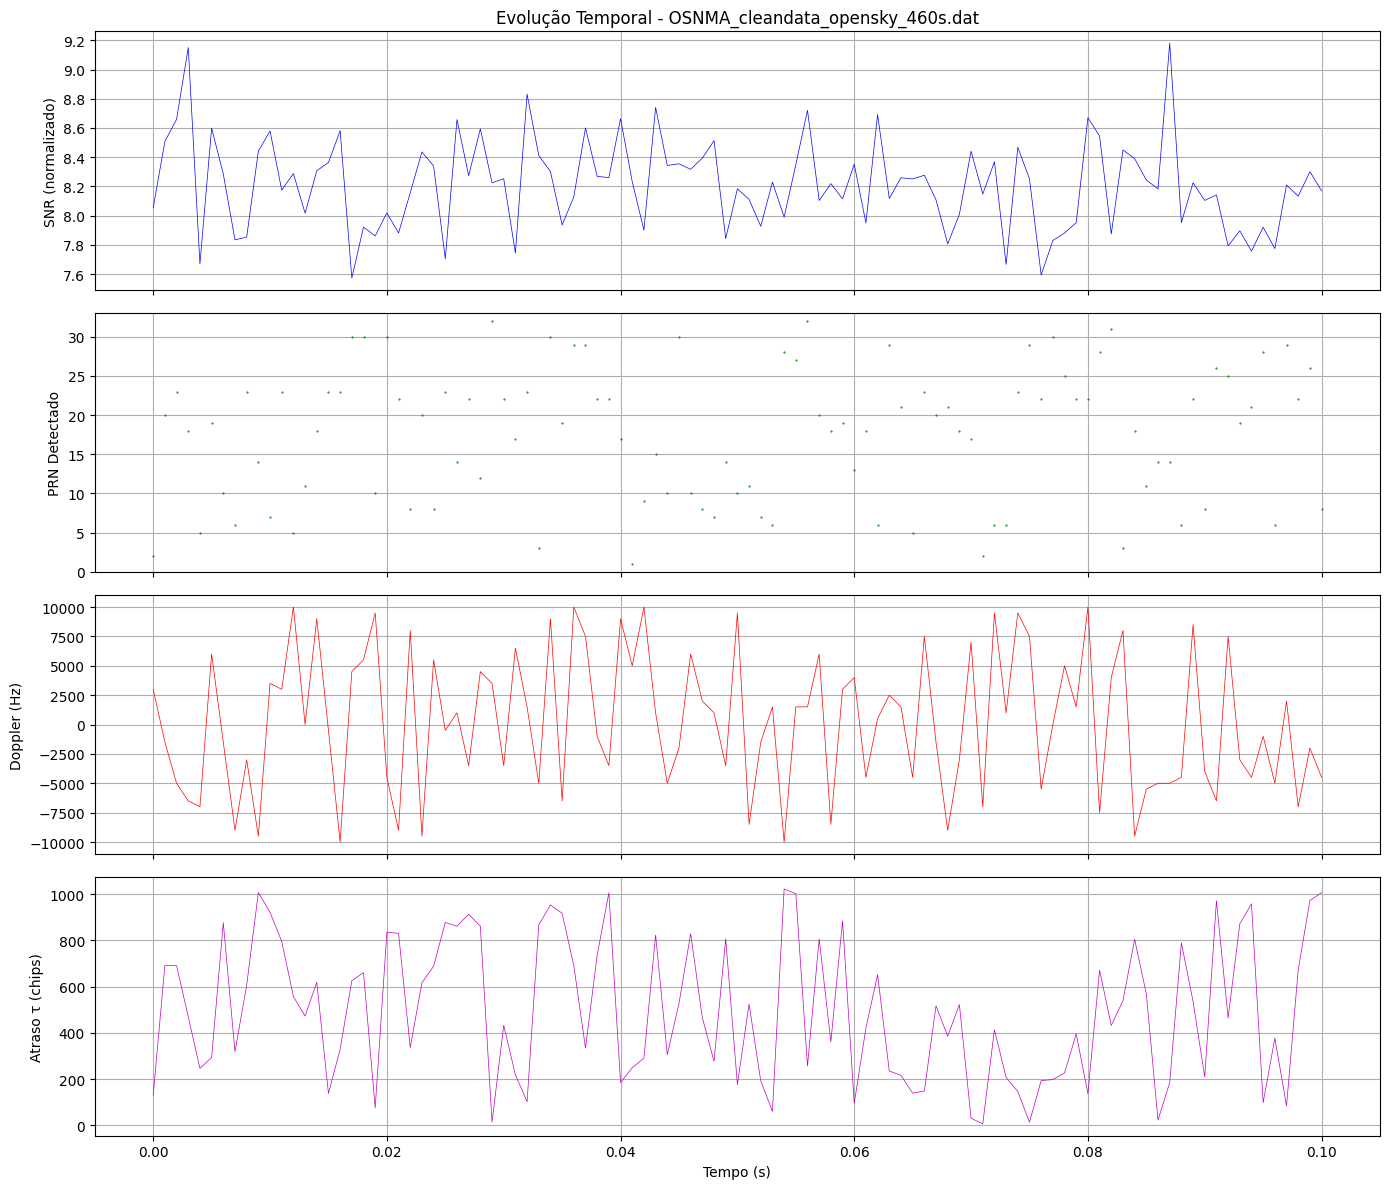


--- Estatísticas Gerais ---
Blocos processados: 101
SNR médio: 8.21
SNR máximo: 9.18
PRN mais frequente: 22
Doppler médio: 163.4 Hz

  PROCESSANDO SINAL SPOOFED

Iniciando aquisição GNSS para o arquivo: /home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat

Processando 101 blocos de 1.0 ms cada
Tempo total: 0.1 segundos
Amostras por bloco: 25575

Lendo arquivo: /home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat


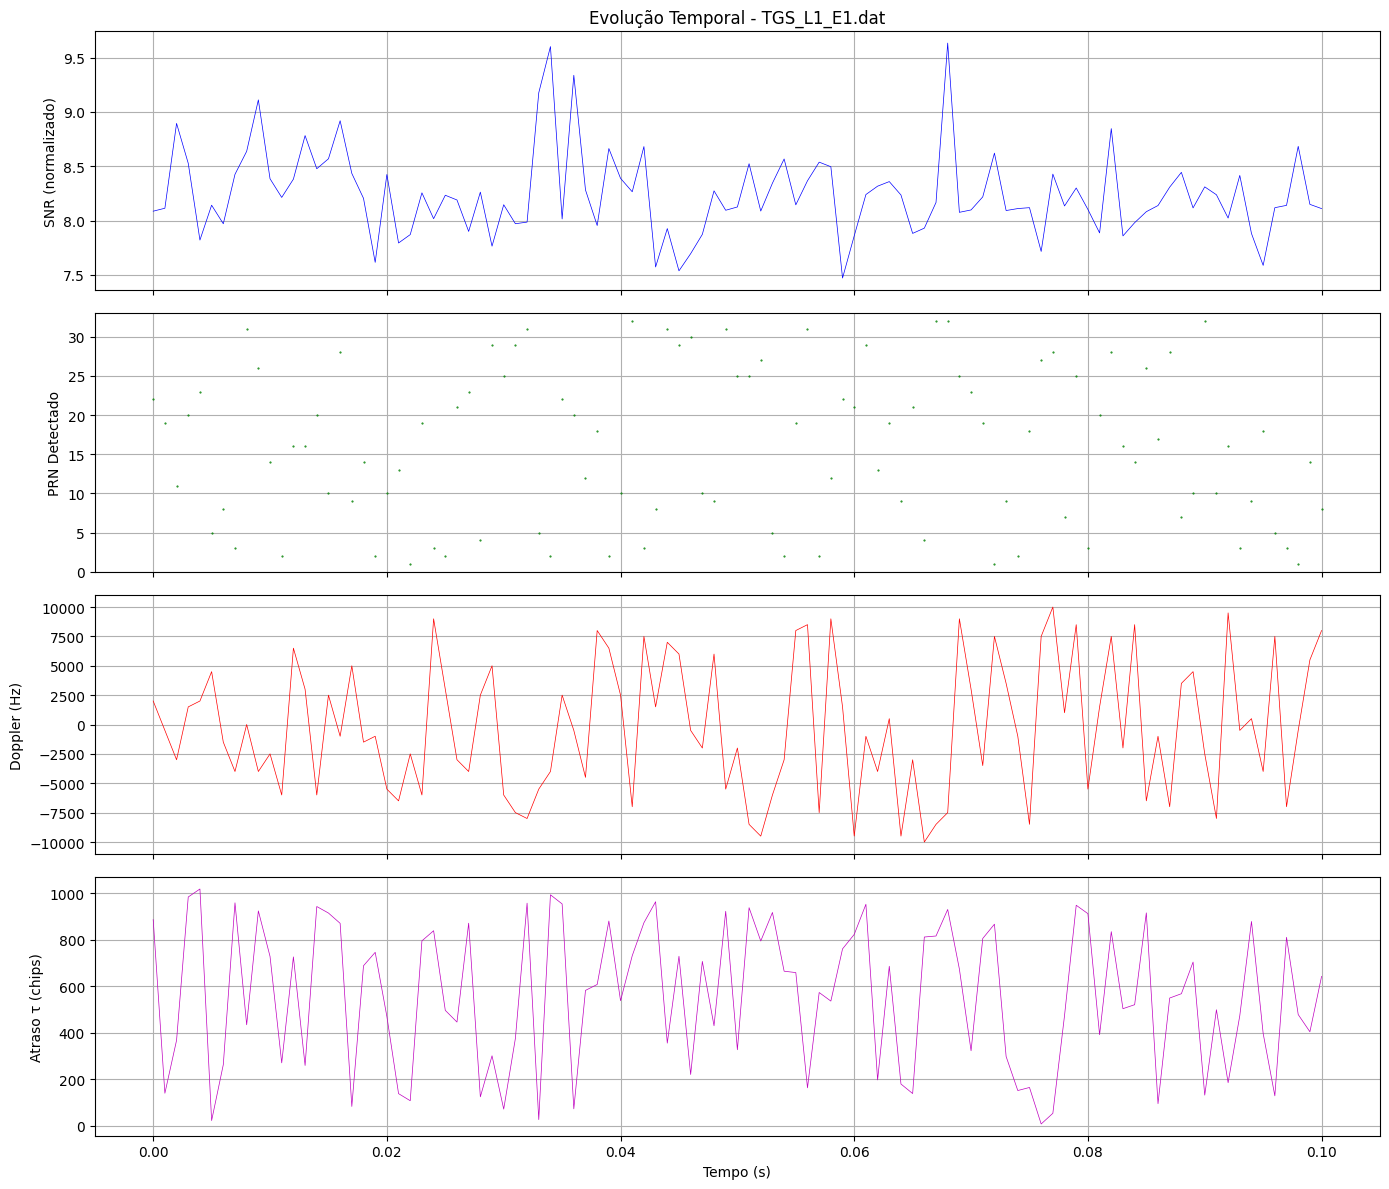


--- Estatísticas Gerais ---
Blocos processados: 101
SNR médio: 8.24
SNR máximo: 9.63
PRN mais frequente: 2
Doppler médio: -282.2 Hz

  RELATÓRIO DE DETECÇÃO DE SPOOFING - CLEAN DATA

📊 ESTATÍSTICAS DE SNR:
   Média: 8.21
   Desvio Padrão: 0.31
   Coef. Variação: 0.038
   Máx/Mín: 9.18 / 7.57
   % acima do threshold: 0.0%

📡 ANÁLISE DOPPLER:
   Média: 163.4 Hz
   Desvio Padrão: 5906.9 Hz
   Taxa média de variação: 7505.00 Hz/ms
   Saltos abruptos: 94 (94.00%)

⏱️ ANÁLISE DE ATRASO (τ):
   Média: 497.06 chips
   Desvio Padrão: 306.87 chips
   Taxa média de variação: 241.6160 chips/ms

🛰️ DIVERSIDADE DE PRN:
   PRNs únicos detectados: 29
   PRNs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32]
   PRN dominante: 22 (9.9%)

📈 ANÁLISE DE POTÊNCIA:
   Média: 836.78
   Coef. Variação: 0.039

🔗 CORRELAÇÃO TEMPORAL:
   Autocorrelação SNR (lag=1): -0.011
   Autocorrelação SNR (lag=10): 0.027

  🎯 SPOOFING SCORE: 30/100
  📋 CLASSIFICAÇÃ

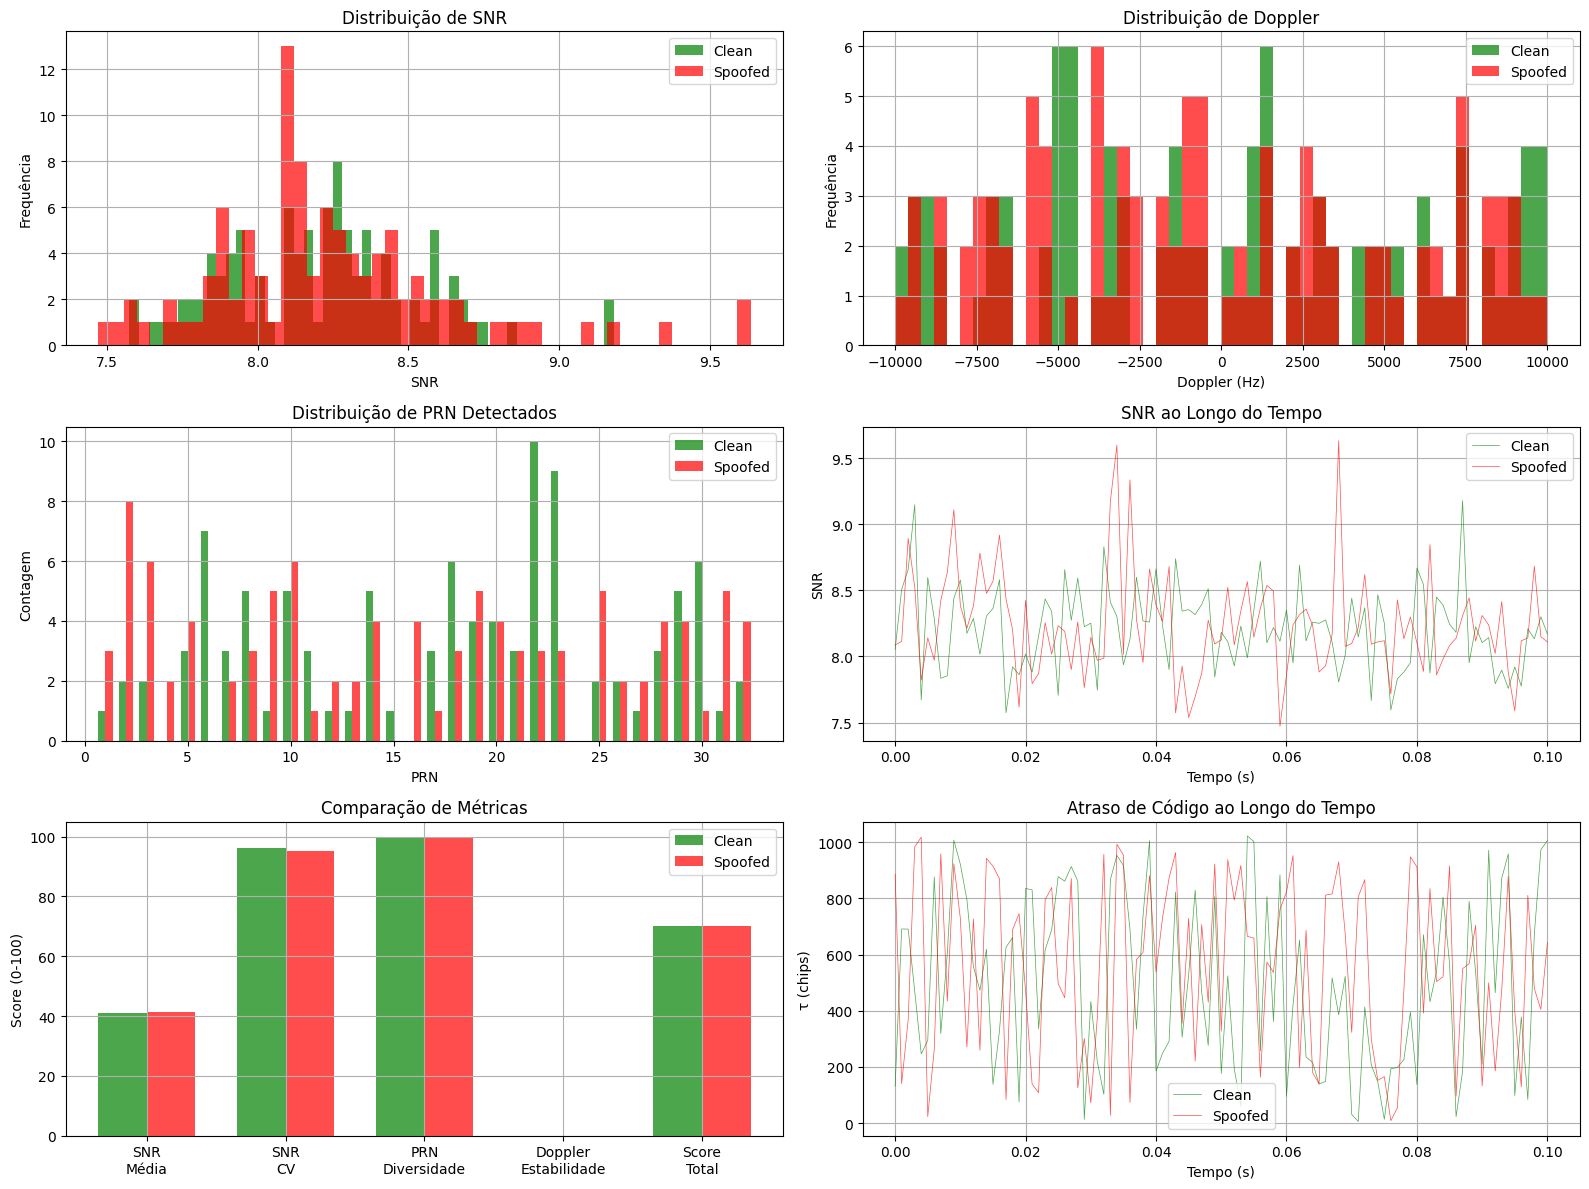

In [43]:
FILENAME_CLEAN = '/home/rc-2d/Downloads/gnss-dataset/OSNMA_cleandata_opensky_460s.dat'
FILENAME_SPOOFED = '/home/rc-2d/Downloads/gnss-dataset/TGS_L1_E1.dat'

# 1. Processar sinal limpo
print("="*70)
print("  PROCESSANDO SINAL LIMPO (CLEAN)")
print("="*70)
results_clean = acquire_gnss_signal(FILENAME_CLEAN)

# 2. Processar sinal spoofed
print("\n" + "="*70)
print("  PROCESSANDO SINAL SPOOFED")
print("="*70)
results_spoofed = acquire_gnss_signal(FILENAME_SPOOFED)

# 3. Calcular métricas de spoofing
if results_clean is not None and results_spoofed is not None:
    metrics_clean = calculate_spoofing_metrics(results_clean, PARAMS_CLEAN)
    metrics_spoofed = calculate_spoofing_metrics(results_spoofed, PARAMS_DS2)
    
    # 4. Imprimir relatórios
    print_spoofing_report(metrics_clean, "CLEAN DATA")
    print_spoofing_report(metrics_spoofed, "SPOOFED DATA")
    
    # 5. Plotar comparação visual
    plot_spoofing_comparison(results_clean, results_spoofed, metrics_clean, metrics_spoofed)